In [2]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from skimage.measure import marching_cubes, find_contours

def compute_surface_area(binary_mask, spacing=(1.0, 1.0, 1.0)):
    """
    Compute the surface area of a binary 3D object using marching cubes.
    """
    verts, faces, normals, _ = marching_cubes(binary_mask, level=0.5, spacing=spacing)
    area = 0.0
    for face in faces:
        v0, v1, v2 = verts[face]
        area += 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
    return area

def compute_perimeter(binary_mask):
    """
    Compute the maximum perimeter of the binary mask across all slices.
    """
    max_perimeter = 0.0
    for slice_index in range(binary_mask.shape[0]):
        contours = find_contours(binary_mask[slice_index, :, :], level=0.5)
        for contour in contours:
            perimeter = np.sum(np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1)))  # Euclidean distance
            if perimeter > max_perimeter:
                max_perimeter = perimeter
    return max_perimeter

def compute_shape_features_3d(seg_array, label, pixel_spacing=(1.0, 1.0, 1.0)):
    """
    Compute 3D shape features for a given label in a segmentation volume.
    """
    mask = (seg_array == label).astype(np.uint8)
    voxel_count = np.sum(mask)
    voxel_volume = np.prod(pixel_spacing)
    volume = voxel_count * voxel_volume
    surface_area = compute_surface_area(mask, spacing=pixel_spacing) if voxel_count > 0 else 0.0
    sphericity = (np.pi**(1/3) * (6 * volume)**(2/3)) / surface_area if surface_area > 0 else 0.0
    equivalent_diameter = (6 * volume / np.pi)**(1/3) if volume > 0 else 0.0
    max_perimeter = compute_perimeter(mask)  # Calculate maximum perimeter
    return {
        "volume": volume,
        "surface_area": surface_area,
        "sphericity": sphericity,
        "equivalent_diameter": equivalent_diameter,
        "max_perimeter": max_perimeter
    }

def read_info_cfg(cfg_path):
    """
    Read the Info.cfg file and return a dictionary with keys: Group, Height, Weight.
    """
    info = {}
    try:
        with open(cfg_path, 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if key in ["Group"]:
                        info[key] = value
                    elif key in ["Height", "Weight"]:
                        info[key] = float(value)  # Convert to float
    except Exception as e:
        print(f"Error reading {cfg_path}: {e}")
    return info

# ----------------------------------------------------------------
# Combined processing over all patients in the training split.
# ----------------------------------------------------------------
base_folder = "./dataset/train"
num_classes = 4  # 0 (background) and three foreground labels (1, 2, 3)
all_records = {}

# Label mapping
label_names = {
    1: "Right Ventricle",
    2: "Myocardium",
    3: "Left Ventricle"
}

for patient in sorted(os.listdir(base_folder)):
    patient_path = os.path.join(base_folder, patient)
    if os.path.isdir(patient_path):
        # Read Info.cfg if it exists.
        cfg_path = os.path.join(patient_path, "Info.cfg")
        patient_info = read_info_cfg(cfg_path) if os.path.exists(cfg_path) else {}
        
        # Initialize a record for the patient
        patient_record = {
            "Patient": patient,
            "Group": patient_info.get("Group", ""),
            "Height": patient_info.get("Height", ""),
            "Weight": patient_info.get("Weight", ""),
        }
        
        # Get sorted list of ground truth files (those containing '_gt').
        gt_files = sorted([f for f in os.listdir(patient_path) if f.endswith('.nii') and '_gt' in f])
        phases = ["ED", "ES"]  # assume first file = ED, second = ES
        
        # Store features for each phase
        phase_features = {phase: {} for phase in phases}
        
        for i, gt_file in enumerate(gt_files):
            phase = phases[i] if i < len(phases) else f"Phase{i+1}"
            gt_path = os.path.join(patient_path, gt_file)
            
            # Load segmentation image.
            img = sitk.ReadImage(gt_path)
            seg_array = sitk.GetArrayFromImage(img)  # shape: (Z, Y, X)
            spacing = img.GetSpacing()                # (x, y, z)
            pixel_spacing = (spacing[2], spacing[1], spacing[0])
            
            # Compute pixel counts for all classes.
            counts = np.bincount(seg_array.flatten(), minlength=num_classes)
            
            # For each foreground label (1, 2, 3).
            for lbl in range(1, num_classes):
                shape_feats = compute_shape_features_3d(seg_array, lbl, pixel_spacing=pixel_spacing)
                # Store features for the current label and phase
                phase_features[phase][lbl] = shape_feats
                phase_features[phase][lbl]["PixelCount"] = counts[lbl]

        # Update patient record with features for both phases
        for lbl in range(1, num_classes):
            for feature in phase_features["ED"][lbl]:
                patient_record[f"{feature} ({label_names[lbl]} - ED)"] = phase_features["ED"][lbl][feature]
            for feature in phase_features["ES"][ lbl]:
                patient_record[f"{feature} ({label_names[lbl]} - ES)"] = phase_features["ES"][lbl][feature]

            # Calculate differences between ED and ES features
            for feature in phase_features["ED"][lbl]:
                if feature != "PixelCount":  # Skip pixel count for difference calculation
                    ed_value = phase_features["ED"][lbl][feature]
                    es_value = phase_features["ES"][lbl][feature]
                    difference = ed_value - es_value
                    patient_record[f"{feature} Difference ({label_names[lbl]} - ED to ES)"] = difference

        # Add the patient record to all records
        all_records[patient] = patient_record

# Create a DataFrame from the records.
if all_records:
    df = pd.DataFrame.from_dict(all_records, orient='index')
    print("Combined global shape features, pixel counts, and differences for all patients:")
    print(df)
    df.to_csv("train_combined_global_features_all_patients_with_differences.csv", index=False)
else:
    print("No ground truth files found.")

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient001/patient001_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient001/patient001_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient001/patient001_frame12_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient001/patient001_frame12_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient002/patient002_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient002/patient002_frame01_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient002/patient002_frame12_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f738e35cd0): ./dataset/train/patient002/patient002_frame12_gt.nii has unexpected scales in sform

NiftiImageIO (0x55f73ad7e660): ./dataset/train/patient003/patient003_fra

Combined global shape features, pixel counts, and differences for all patients:
               Patient Group  Height  Weight  volume (Right Ventricle - ED)  \
patient001  patient001   DCM   184.0    95.0                  139721.679688   
patient002  patient002   DCM   160.0    70.0                   94432.067871   
patient003  patient003   DCM   165.0    77.0                  192333.984375   
patient004  patient004   DCM   159.0    46.0                  106264.114380   
patient005  patient005   DCM   165.0    77.0                  170463.867188   
...                ...   ...     ...     ...                            ...   
patient096  patient096    RV   186.0    76.0                  284093.106129   
patient097  patient097    RV   187.0    82.0                  208836.735952   
patient098  patient098    RV   167.0    50.0                  164656.250000   
patient099  patient099    RV   180.0    80.0                  200365.742297   
patient100  patient100    RV   165.0    63.0       

2025-03-21 16:28:13.651936: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-21 16:28:13.689477: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-03-21 16:28:13.689497: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-03-21 16:28:13.689520: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-21 16:28:13.697164: I tensorflow/core/platform/cpu_feature_g

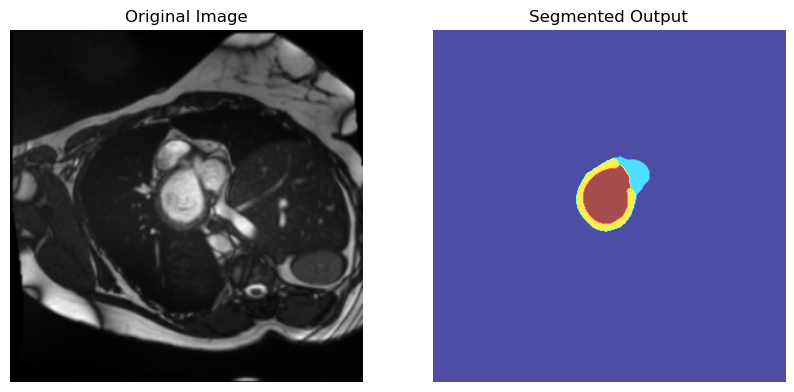

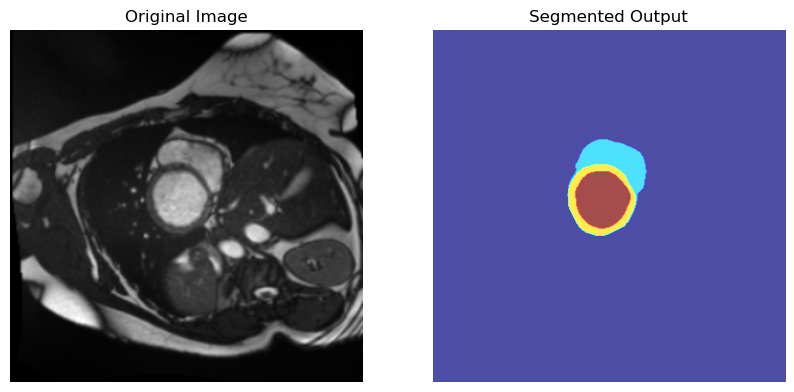

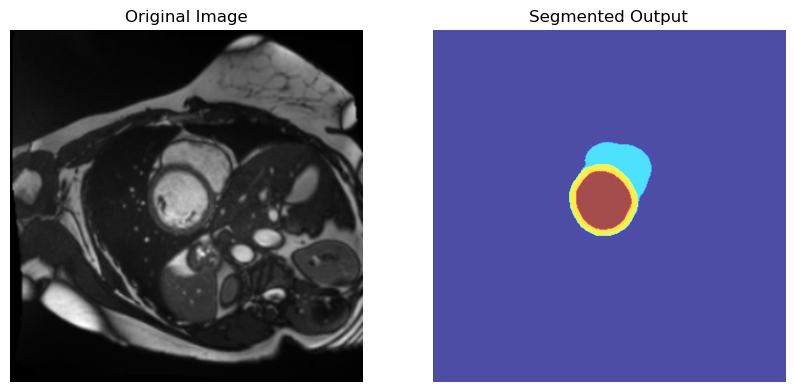

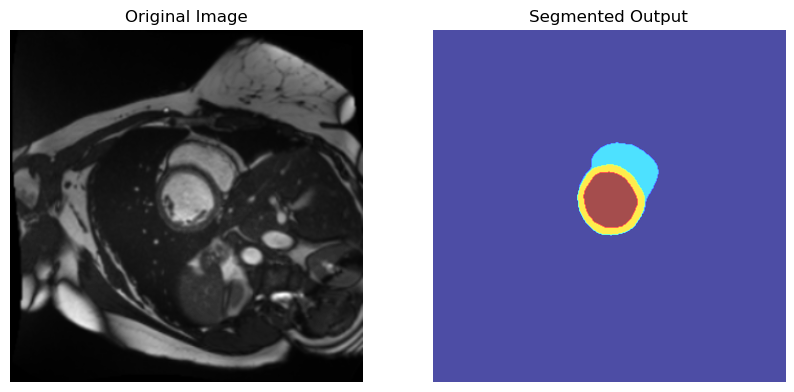

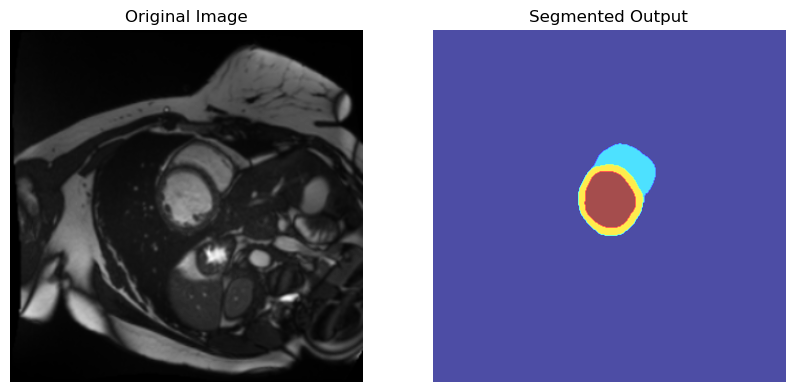

Segmentation completed. All files saved to: ./dataset/test_2d_segmented


In [1]:
import os
import torch
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from scipy.ndimage import label
from monai.networks.nets import UNet
from monai.transforms import Compose, LoadImage, EnsureChannelFirst, Resize, ToTensor

# Define paths
test_data_dir = "./dataset/test_2d"
output_dir = "./dataset/test_2d_segmented"
model_path = "2DUnet_no_augmentation_train_1903.pth"

# Ensure the output directory exists
os.makedirs(output_dir, exist_ok=True)

# Load trained model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(
    spatial_dims=2, in_channels=1, out_channels=4,
    channels=(64, 128, 256, 512, 1024, 2048),
    strides=(2, 2, 2, 2, 2),
    num_res_units=3, norm="batch", dropout=0.2
)
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)
model.eval()

# Define image transformations
transforms = Compose([
    LoadImage(image_only=True),
    EnsureChannelFirst(),
    Resize((352, 352)),
    ToTensor()
])

# Function to keep the largest connected component
def keep_largest_component(pred_mask, min_size=50):
    output = np.zeros_like(pred_mask)
    for cls in np.unique(pred_mask):
        if cls == 0:
            continue
        binary_mask = (pred_mask == cls).astype(np.int32)
        labeled_array, num_features = label(binary_mask)
        if num_features == 0:
            continue
        sizes = np.bincount(labeled_array.ravel())
        sizes[0] = 0
        largest_label = sizes.argmax()
        if sizes[largest_label] >= min_size:
            largest_component = (labeled_array == largest_label)
            output[largest_component] = cls
    return output

# Process each patient
test_patients = sorted(os.listdir(test_data_dir))
num_visualizations = 5  # Number of segmentations to visualize
visualized = 0

for patient in test_patients:
    patient_path = os.path.join(test_data_dir, patient)
    if os.path.isdir(patient_path):
        output_patient_path = os.path.join(output_dir, patient)
        os.makedirs(output_patient_path, exist_ok=True)
        
        for file in sorted(os.listdir(patient_path)):
            if file.endswith(".nii") and "_gt" not in file:
                image_path = os.path.join(patient_path, file)
                output_path = os.path.join(output_patient_path, file)
                
                # Load and preprocess image
                image = transforms(image_path).to(device).unsqueeze(0)
                
                # Perform segmentation
                with torch.no_grad():
                    output = model(image)
                    pred = torch.argmax(output, dim=1).cpu().numpy().squeeze()
                    
                    # Apply post-processing: Keep the largest connected component
                    processed_pred = keep_largest_component(pred, min_size=50)
                
                # Save prediction as NIfTI file
                sitk_image = sitk.GetImageFromArray(processed_pred.astype(np.uint8))
                sitk.WriteImage(sitk_image, output_path)
                #print(f"Saved segmentation: {output_path}")
                
                # Visualization
                if visualized < num_visualizations:
                    original_image = transforms(image_path).cpu().numpy().squeeze()
                    
                    plt.figure(figsize=(10, 5))
                    plt.subplot(1, 2, 1)
                    plt.imshow(original_image, cmap='gray')
                    plt.title("Original Image")
                    plt.axis("off")
                    
                    plt.subplot(1, 2, 2)
                    plt.imshow(processed_pred, cmap='jet', alpha=0.7)
                    plt.title("Segmented Output")
                    plt.axis("off")
                    
                    plt.show()
                    visualized += 1

print("Segmentation completed. All files saved to:", output_dir)

In [9]:
import os
import SimpleITK as sitk
import numpy as np

# Define input and output directories
input_dir = "./dataset/test_2d_segmented"
output_dir = "./dataset/test_3d_segmented"
os.makedirs(output_dir, exist_ok=True)

# Function to reconstruct 3D with metadata
def reconstruct_3d_volume(slice_files, reference_image):
    slices = [sitk.ReadImage(f) for f in sorted(slice_files)]
    volume_array = np.stack([sitk.GetArrayFromImage(s) for s in slices], axis=0)
    volume_image = sitk.GetImageFromArray(volume_array)

    # Use spacing, origin, direction from reference
    volume_image.SetSpacing(reference_image.GetSpacing())
    volume_image.SetOrigin(reference_image.GetOrigin())
    volume_image.SetDirection(reference_image.GetDirection())

    return volume_image

# Process each patient
test_patients = sorted(os.listdir(input_dir))
for patient in test_patients:
    patient_path = os.path.join(input_dir, patient)
    if os.path.isdir(patient_path):
        output_patient_path = os.path.join(output_dir, patient)
        os.makedirs(output_patient_path, exist_ok=True)

        frame_dict = {}
        for file in sorted(os.listdir(patient_path)):
            if file.endswith(".nii"):
                frame_id = "_".join(file.split("_")[:2])
                if frame_id not in frame_dict:
                    frame_dict[frame_id] = []
                frame_dict[frame_id].append(os.path.join(patient_path, file))

        for frame_id, slice_files in frame_dict.items():
            # Path to the corresponding original .nii reference
            reference_path = f"./dataset/test/{patient}/{frame_id}_gt.nii"
            if not os.path.exists(reference_path):
                print(f"Missing reference image: {reference_path}")
                continue

            reference_image = sitk.ReadImage(reference_path)
            volume = reconstruct_3d_volume(slice_files, reference_image)

            output_path = os.path.join(output_patient_path, f"{frame_id}.nii")
            sitk.WriteImage(volume, output_path)

print("3D reconstruction completed. All files saved to:", output_dir)

3D reconstruction completed. All files saved to: ./dataset/test_3d_segmented


In [10]:
import os
import SimpleITK as sitk
import numpy as np
import pandas as pd
from skimage.measure import marching_cubes, find_contours

def compute_surface_area(binary_mask, spacing=(1.0, 1.0, 1.0)):
    """
    Compute the surface area of a binary 3D object using marching cubes.
    """
    verts, faces, normals, _ = marching_cubes(binary_mask, level=0.5, spacing=spacing)
    area = 0.0
    for face in faces:
        v0, v1, v2 = verts[face]
        area += 0.5 * np.linalg.norm(np.cross(v1 - v0, v2 - v0))
    return area

def compute_perimeter(binary_mask):
    """
    Compute the maximum perimeter of the binary mask across all slices.
    """
    max_perimeter = 0.0
    for slice_index in range(binary_mask.shape[0]):
        contours = find_contours(binary_mask[slice_index, :, :], level=0.5)
        for contour in contours:
            perimeter = np.sum(np.sqrt(np.sum(np.diff(contour, axis=0)**2, axis=1)))
            if perimeter > max_perimeter:
                max_perimeter = perimeter
    return max_perimeter

def compute_shape_features_3d(seg_array, label, pixel_spacing=(1.0, 1.0, 1.0)):
    """
    Compute 3D shape features for a given label in a segmentation volume.
    """
    mask = (seg_array == label).astype(np.uint8)
    voxel_count = np.sum(mask)
    voxel_volume = np.prod(pixel_spacing)
    volume = voxel_count * voxel_volume
    surface_area = compute_surface_area(mask, spacing=pixel_spacing) if voxel_count > 0 else 0.0
    sphericity = (np.pi**(1/3) * (6 * volume)**(2/3)) / surface_area if surface_area > 0 else 0.0
    equivalent_diameter = (6 * volume / np.pi)**(1/3) if volume > 0 else 0.0
    max_perimeter = compute_perimeter(mask)
    return {
        "volume": volume,
        "surface_area": surface_area,
        "sphericity": sphericity,
        "equivalent_diameter": equivalent_diameter,
        "max_perimeter": max_perimeter
    }

def read_info_cfg(cfg_path):
    """
    Read the Info.cfg file and return a dictionary with keys: Group, Height, Weight.
    """
    info = {}
    try:
        with open(cfg_path, 'r') as f:
            for line in f:
                if ':' in line:
                    key, value = line.split(":", 1)
                    key = key.strip()
                    value = value.strip()
                    if key in ["Group", "Height", "Weight"]:
                        info[key] = value if key == "Group" else float(value)
    except Exception as e:
        print(f"Error reading {cfg_path}: {e}")
    return info

# Process the 3D segmentations
base_folder = "./dataset/test_3d_segmented"
info_folder = "./dataset/test"
num_classes = 4  # Background + three foreground labels
all_records = {}

label_names = {1: "Right Ventricle", 2: "Myocardium", 3: "Left Ventricle"}

for patient in sorted(os.listdir(base_folder)):
    if patient == ".ipynb_checkpoints":
        continue  # Skip unwanted checkpoint folders
    
    patient_path = os.path.join(base_folder, patient)
    info_path = os.path.join(info_folder, patient, "Info.cfg")
    
    if os.path.isdir(patient_path):
        patient_info = read_info_cfg(info_path) if os.path.exists(info_path) else {}
        
        patient_record = {
            "Patient": patient,
            "Group": patient_info.get("Group", ""),
            "Height": patient_info.get("Height", ""),
            "Weight": patient_info.get("Weight", ""),
        }
        
        seg_files = sorted([f for f in os.listdir(patient_path) if f.endswith('.nii')])
        phases = ["ED", "ES"]
        
        if len(seg_files) >= 2:
            phase_features = {}
            for i, seg_file in enumerate(seg_files[:2]):
                phase = phases[i]
                seg_path = os.path.join(patient_path, seg_file)
                
                img = sitk.ReadImage(seg_path)
                seg_array = sitk.GetArrayFromImage(img)
                spacing = img.GetSpacing()
                pixel_spacing = (spacing[2], spacing[1], spacing[0])
                
                phase_features[phase] = {}
                for lbl in range(1, num_classes):
                    phase_features[phase][lbl] = compute_shape_features_3d(seg_array, lbl, pixel_spacing=pixel_spacing)
                    phase_features[phase][lbl]["PixelCount"] = np.sum(seg_array == lbl)
                
                for lbl in range(1, num_classes):
                    for feature in phase_features[phase][lbl]:
                        patient_record[f"{feature} ({label_names[lbl]} - {phase})"] = phase_features[phase][lbl][feature]
            
            for lbl in range(1, num_classes):
                for feature in phase_features["ED"].get(lbl, {}):
                    if feature != "PixelCount":
                        ed_value = patient_record.get(f"{feature} ({label_names[lbl]} - ED)", 0)
                        es_value = patient_record.get(f"{feature} ({label_names[lbl]} - ES)", 0)
                        patient_record[f"{feature} Difference ({label_names[lbl]} - ED to ES)"] = ed_value - es_value
        
        all_records[patient] = patient_record

if all_records:
    df = pd.DataFrame.from_dict(all_records, orient='index')
    df.to_csv("own_segmentation_combined_global_features_all_patients_with_differences.csv", index=False)
    print("Feature table saved.")
else:
    print("No segmentation files found.")

Feature table saved.


In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Load the training and testing datasets
train_file_path = "train_combined_global_features_all_patients_with_differences.csv"
test_file_path = "own_segmentation_combined_global_features_all_patients_with_differences.csv"

df_train = pd.read_csv(train_file_path)
df_test = pd.read_csv(test_file_path)

# Ensure consistent column order and remove 'Patient' column if present
if "Patient" in df_train.columns:
    df_train.drop(columns=["Patient"], inplace=True)
if "Patient" in df_test.columns:
    df_test.drop(columns=["Patient"], inplace=True)

# Encode the target variable
label_encoder = LabelEncoder()
df_train["Group"] = label_encoder.fit_transform(df_train["Group"])
df_test["Group"] = label_encoder.transform(df_test["Group"])

# Extract features present in the training set (to avoid missing columns issue)
feature_columns = [col for col in df_train.columns if col != "Group"]
X_train = df_train[feature_columns]
y_train = df_train["Group"]

# Ensure test data has the same features
X_test = df_test.reindex(columns=feature_columns, fill_value=0)
y_test = df_test["Group"]

# Train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Make predictions
y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))


Accuracy: 0.78
Classification Report:
              precision    recall  f1-score   support

         DCM       0.75      0.90      0.82        10
         HCM       1.00      1.00      1.00        10
        MINF       0.88      0.70      0.78        10
         NOR       1.00      0.30      0.46        10
          RV       0.59      1.00      0.74        10

    accuracy                           0.78        50
   macro avg       0.84      0.78      0.76        50
weighted avg       0.84      0.78      0.76        50



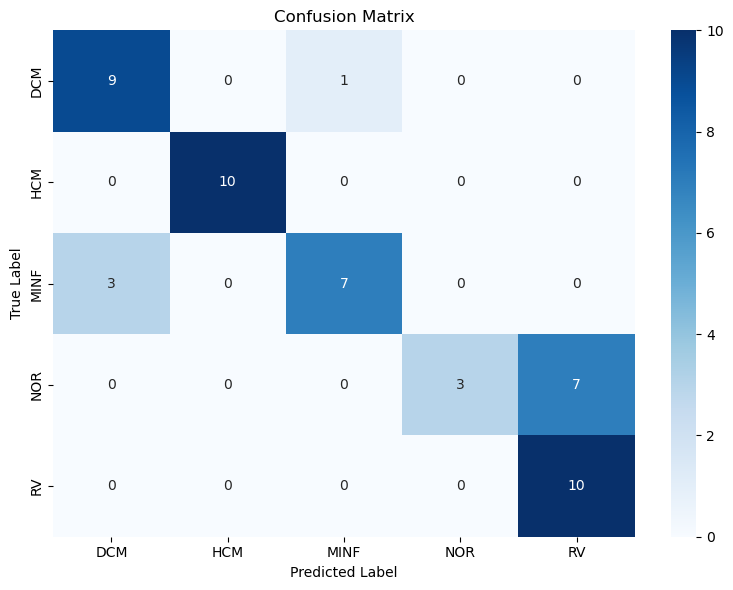

In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


In [ ]:
# Disclaimer:
# This code has been developed with assistance from ChatGPT to support functionality and error handling.
# The authors take full responsibility for its content, functionality, and any outcomes resulting from its use.